# PATTERN & HYPO tools


In [186]:
import numpy as np
import pandas as pd
from numpy.random import randn
np.random.seed(101)
DATA_DIR = '/Users/nathanzhao/Desktop/Python_quant_finance' + \
        '/Python-for-Finance-Repo-master-master' + \
        '/08-Time-Series-Analysis' 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

In [187]:
df = sm.datasets.macrodata.load_pandas().data
index = pd.Index(sm.tsa.datetools.dates_from_range  ('1959Q1','2009Q3'))
df.index = index

# Pattern:
* ### Binplots VA1, w/ DF partitioned by VA2
* ### Binplots VA1, w/ DF partitioned by list of pairs of bounds ofg VA2 (ONLY FOR int, float, datetime)
* ### TODO: Binplot by categorical variable (all OR selected subset among all)

# Hypo:
* ### TODO: two group mean test, MIX with Binplot 1
* ### TODO: linear regression test, related to Binplot 1

# TODO: 
* look at the python hypo test post on right side, cross check with my theory notes.
* come up with more, useful patterns & hypo funcs

================================================
================================================

# Binplots VA1, w/ DF partitioned by VA2

In [259]:
def BINPLOT_VA1_parted_eq_by_VA2(
        df, 
        num_q, 
        va1, 
        va2, 
        va2_is_index = False, 

        apply_float_precision = True,
        precision_float = 2,
    
        whether_plot = True,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    """
    Params:
        【va2_is_index】 True:
                Then 【va2】 is just a name of x axis
        【apply_float_precision】 True: 
                Only when 【va2】 is float/int
    Returns: 
        DataFrame of means & stds
    Note:
        Require no repeating index, for time series index, 
            consider push repeating index by 1ns, repeat 
            until no repetition left.
            
    TODO:  Implement smart remove of repeat index
    """
    # partition
    if va2_is_index:
        unstacked = df[va1].groupby(pd.qcut(df.index, q = num_q)).apply(pd.DataFrame)
    else:
        unstacked = df[va1].groupby(pd.qcut(df[va2], q = num_q)).apply(pd.DataFrame)
    precision_str = "{:." + str(precision_float) + "f}"
    if apply_float_precision:
        columns_interval_left = list(map(lambda x : precision_str.format(x.left), list(unstacked.columns)))
    else :
        columns_interval_left = list(map(lambda x : x.left, list(unstacked.columns)))
        
    # plot
    if whether_plot:
        ax = pd.DataFrame(unstacked.values).plot(kind='box',figsize = fig_size)
        if show_x_ticks:
            _ = ax.set_xticklabels(columns_interval_left)
        _ = ax.set_xlabel("LEFT of {" + va2 + "}")
        _ = ax.set_ylabel(va1)
    
    # return
    ls_means = list(unstacked.mean(axis = 0, skipna = True))
    ls_stds = list(unstacked.std(axis = 0, skipna = True))
    df_ret = pd.DataFrame(data = ([ls_means, ls_stds]),
                          index = ['mean','std'],
                          columns = columns_interval_left)
    df_ret = df_ret.transpose()
    df_ret.rename_axis("LEFT of {" + va2 + "}", inplace = True)
    return df_ret

,mean,std
LEFT of {realinv},,
259.76,4542.966559,1171.174336
896.21,9925.894129,2188.223177


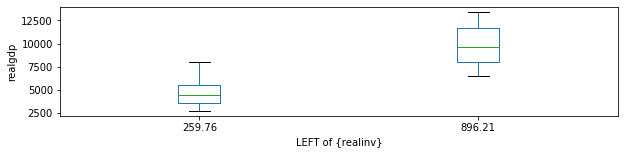

In [262]:
BINPLOT_VA1_parted_eq_by_VA2(
    df= df, 
    va1=  'realgdp', 
    va2 = 'realinv', 
    num_q =2, 
    va2_is_index = False, 
    apply_float_precision = True,
    precision_float = 2,
    fig_size = (10,2), 
    show_x_ticks = True
)

# Binplots VA1, w/ DF partitioned by list of pairs of bounds ofg VA2 
* (ONLY FOR int, float, datetime)

In [ ]:
def BINPLOT_VA1_parted_by_list_of_pairs_of_VA2(
        df, 
        va1, 
        va2, 
        ls,
        va2_is_index = False, 

        apply_float_precision = True,
        precision_x_axis = 2,
        fig_size = (16,4),
        show_x_ticks = True
    ): 
    UNIQUE_ID_COL = 'unique_group_identifier_to_be_deleted_by_nathan_3434344' 
    df[UNIQUE_ID_COL] = -1
    
    
    
    
    
    df.drop(UNIQUE_ID_COL, axis = 1)

In [193]:
pd.to_datetime("20190102") > pd.to_datetime("20190101")

True

In [204]:
ls_means = df.mean(axis = 0, skipna = True) 

In [205]:
ls_means 

year        1983.876847
quarter        2.492611
realgdp     7221.171901
realcons    4825.293103
realinv     1012.863862
realgovt     663.328640
realdpi     5310.540887
cpi          105.075788
m1           667.927586
tbilrate       5.311773
unemp          5.884729
pop          239.724153
infl           3.961330
realint        1.336502
dtype: float64